In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import os
import cv2
import glob
from PIL import Image

In [3]:
import warnings
warnings.filterwarnings("ignore")

## PART A

In [4]:
data= np.load("C:/users/user/downloads/images.npy",allow_pickle= True)

In [5]:
data.shape

(409, 2)

In [6]:
data[0]

array([array([[[42, 37, 34],
               [56, 51, 48],
               [71, 66, 63],
               ...,
               [23, 33, 34],
               [26, 36, 37],
               [28, 38, 39]],

              [[40, 35, 32],
               [51, 46, 43],
               [64, 59, 56],
               ...,
               [27, 36, 35],
               [24, 33, 32],
               [26, 35, 34]],

              [[43, 38, 35],
               [51, 46, 43],
               [61, 56, 53],
               ...,
               [28, 30, 27],
               [33, 35, 32],
               [35, 37, 34]],

              ...,

              [[56, 47, 40],
               [57, 48, 41],
               [61, 52, 45],
               ...,
               [67, 48, 42],
               [55, 35, 28],
               [60, 40, 33]],

              [[53, 44, 37],
               [54, 45, 38],
               [57, 48, 41],
               ...,
               [59, 40, 34],
               [60, 40, 33],
               [54, 34, 27]],



In [7]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [8]:
data[0][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

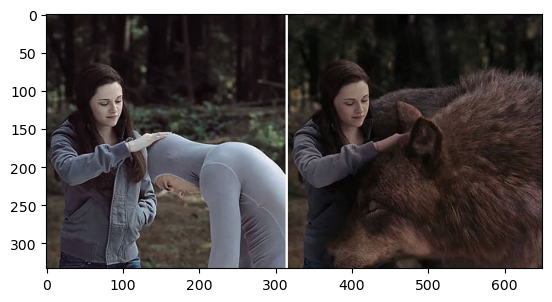

In [9]:
plt.imshow(data[0][0])

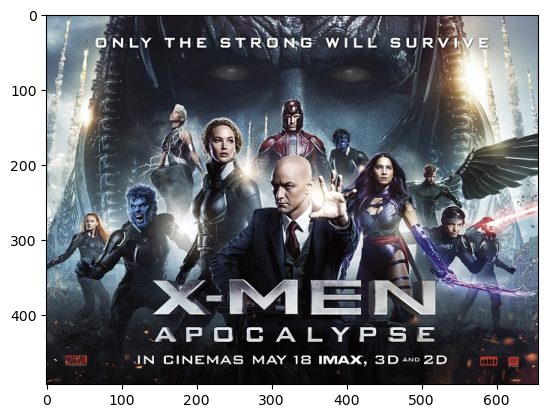

In [10]:
plt.imshow(data[408][0])

In [11]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

In [14]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [27]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
    img = img[:,:,:3]# alpha channel
  except:
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    
    masks[index][y1:y2, x1:x2] = 1 # coordinates to 1


In [28]:
X.shape

(409, 224, 224, 3)

In [29]:
masks.shape

(409, 224, 224)

In [30]:
# train test split
X_train = X[:400]
x_test=X[400:409]
Y_train=masks[:400]
y_test=masks[400:409]

In [31]:
print(X_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(y_test.shape)



(400, 224, 224, 3)
(9, 224, 224, 3)
(400, 224, 224)
(9, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


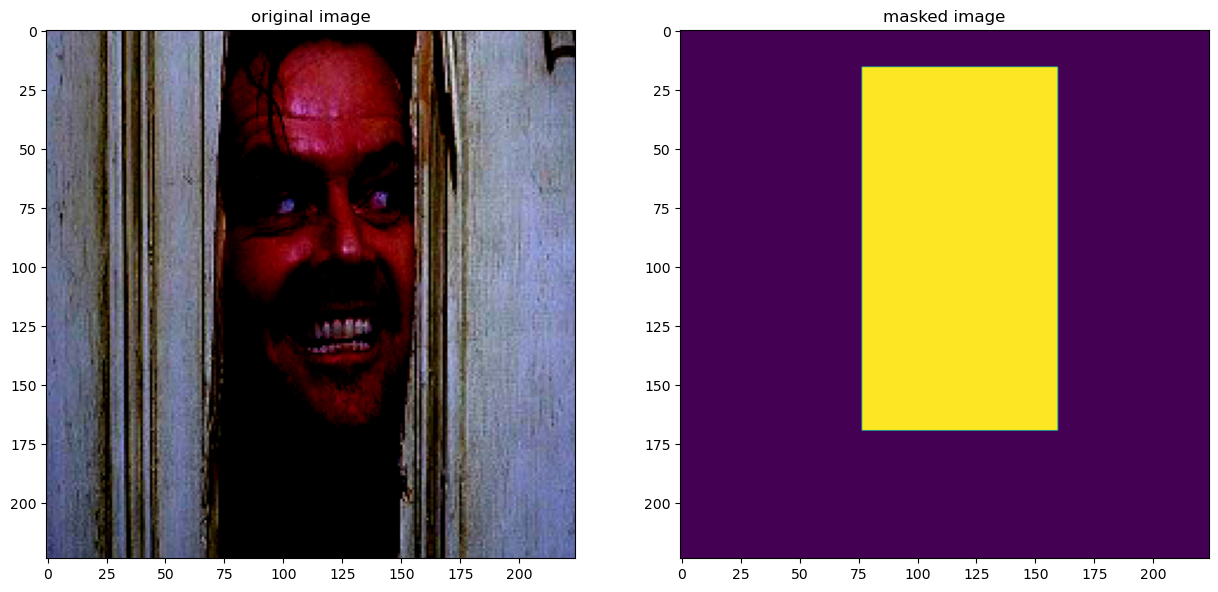

In [33]:
fig = plt.figure(figsize=(15, 7))
a = fig.add_subplot(1, 2,1)
plt.title('original image')
img = plt.imshow(X_train[150])
a = fig.add_subplot(1, 2,2)
plt.title('masked image')
imgm=plt.imshow(Y_train[150])



#### Model Building

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate,Reshape
from tensorflow.keras.applications import MobileNet

In [55]:
def create_model():
    model= MobileNet(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),include_top = False, weights='imagenet')
    for layer in model.layers:
        layer.trainable=False
        block1= model.get_layer("conv_pw_5_relu").output
        block2=model.get_layer("conv_pw_11_relu").output
        block3=model.get_layer("conv_pw_13_relu").output
        x= Concatenate()([UpSampling2D()(block3),block2])
        x=Concatenate()([UpSampling2D()(x),block1])
        x=Conv2D(1,kernel_size=1,activation="sigmoid")(x)
        x=Reshape((HEIGHT_CELLS,WIDTH_CELLS)) (x)
        model= Model(inputs=model.input, outputs=x)
        #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['dice_coefficient'])
        return model

In [56]:
final_model=create_model()

In [57]:
#final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['dice_coefficient'])
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']      

                                                                                                  
 conv_pw_5 (Conv2D)          (None, 28, 28, 256)          65536     ['conv_dw_5_relu[0][0]']      
                                                                                                  
 conv_pw_5_bn (BatchNormali  (None, 28, 28, 256)          1024      ['conv_pw_5[0][0]']           
 zation)                                                                                          
                                                                                                  
 conv_pw_5_relu (ReLU)       (None, 28, 28, 256)          0         ['conv_pw_5_bn[0][0]']        
                                                                                                  
 conv_pad_6 (ZeroPadding2D)  (None, 29, 29, 256)          0         ['conv_pw_5_relu[0][0]']      
                                                                                                  
 conv_dw_6

 conv_pw_10_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_pw_10_bn[0][0]']       
                                                                                                  
 conv_dw_11 (DepthwiseConv2  (None, 14, 14, 512)          4608      ['conv_pw_10_relu[0][0]']     
 D)                                                                                               
                                                                                                  
 conv_dw_11_bn (BatchNormal  (None, 14, 14, 512)          2048      ['conv_dw_11[0][0]']          
 ization)                                                                                         
                                                                                                  
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_dw_11_bn[0][0]']       
                                                                                                  
 conv_pw_1

In [65]:
import tensorflow as tf

In [71]:
def dice_coefficient(y_true,y_pred):
    numerator= 2*tf.reduce_sum(y_true*y_pred)
    denominator=tf.reduce_sum(y_true+y_pred)
    dice_coefficient= numerator/(denominator + tf.keras.backend.epsilon())
    return dice_coefficient

In [67]:
def loss(y_true, y_pred):
    loss= binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())
    return loss

In [73]:
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient], run_eagerly= True)

In [69]:
y_Train = np.array([cv2.resize(masks, (final_model.output_shape[1], final_model.output_shape[2])) for masks in Y_train])
y_Test = np.array([cv2.resize(masks, (final_model.output_shape[1], final_model.output_shape[2])) for masks in y_test])

In [74]:
history= final_model.fit(X_train, y_Train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
13/13 [==============================] - 1543s 70s/step - loss: 0.4593 - dice_coefficient: 0.4447
Epoch 2/5
13/13 [==============================] - 826s 63s/step - loss: 0.1984 - dice_coefficient: 0.6216
Epoch 3/5
13/13 [==============================] - 183s 12s/step - loss: 0.1462 - dice_coefficient: 0.6778
Epoch 4/5
13/13 [==============================] - 277s 22s/step - loss: 0.1238 - dice_coefficient: 0.7040
Epoch 5/5
13/13 [==============================] - 157s 12s/step - loss: 0.1101 - dice_coefficient: 0.7429


#### Insights:
- the loss is decreasing  significantly which on further implementation of epoch may decrease and learn further
- Accuracy also not bad for 5 epoch it is increasing consistently  on the training set. 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


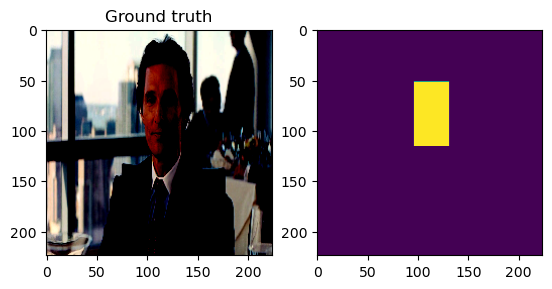

In [139]:
# test image
plt.title('original image')
plt.subplot(1,2,1)
img = plt.imshow(x_test[3])

plt.title("Ground truth")
plt.subplot(1,2,2)
img1=plt.imshow(y_test[3])


In [137]:
x_test[3].shape

(224, 224, 3)

In [138]:
y_Test[3].shape

(28, 28)